https://www.youtube.com/watch?v=Mn_9W1nCFLo&ab_channel=UmarJamil

https://github.com/meta-llama/llama/blob/main/llama/model.py

In [ ]:
!pip install -q nltk datasets torchtune

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.6/350.6 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.3/409.3 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 85.8 MB/s eta 0:00:00
ERR

In [ ]:
import torch
import torch.nn as nn
import math
from transformers import GPT2Tokenizer
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import nltk
nltk.download('punkt')

from nltk.tokenize import sent_tokenize
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torchtune
import torch.nn.functional as F

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
DEVICE = torch.device('cuda:0')

In [ ]:
text = []
with open('input.txt', 'r', encoding='utf-8') as f:
    for l in f:
        if l.strip() == '':
            continue
        text.append(l.strip())

sentences = sent_tokenize(' '.join(text), language='english')
train_sentences = sentences[:10000]
test_sentences = sentences[10000:]

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, tok, max_length = 30):
        self.data = data
        self.tok = tok
        self.max_length = max_length

    def __len__(self):

        return len(self.data)

    def __getitem__(self, idx):

        data = self.data[idx]

        data_tokens = self.tok(data, return_tensors = 'pt', max_length = self.max_length, truncation=True, padding = 'max_length')

        data_input_ids = data_tokens['input_ids'][0]
        data_attention_mask = data_tokens['attention_mask'][0]

        input_ids = data_input_ids[:-1]
        labels_ids = data_input_ids[1:]

        return input_ids, labels_ids, data_attention_mask[1:].bool()

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, seq_len):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        # Create a matrix of shape (seq_len, d_model)
        pe = torch.zeros(seq_len, d_model)
        # Create a vector of shape (seq_len)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (seq_len, 1)
        # Create a vector of shape (d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # (d_model / 2)
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term) # sin(position * (10000 ** (2i / d_model))
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term) # cos(position * (10000 ** (2i / d_model))
        # Add a batch dimension to the positional encoding
        pe = pe.unsqueeze(0) # (1, seq_len, d_model)
        # Register the positional encoding as a buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) # (batch, seq_len, d_model)
        return x

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, qkv_bias = True):
        super().__init__()
        assert d_model % n_heads == 0, "d_model is not divisible by h"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.query = nn.Linear(d_model, d_model, bias = qkv_bias)
        self.key = nn.Linear(d_model, d_model, bias = qkv_bias)
        self.value = nn.Linear(d_model, d_model, bias = qkv_bias)
        self.out = nn.Linear(d_model, d_model)
        self.scale = self.d_head ** -0.5

    def forward(self, x):
        B, S, D = x.shape
        query = self.query(x).view(B, S, self.n_heads, self.d_head).permute(0, 2, 1, 3)
        key = self.key(x).view(B, S, self.n_heads, self.d_head).permute(0, 2, 1, 3)
        value = self.value(x).view(B, S, self.n_heads, self.d_head).permute(0, 2, 1, 3)

        dots = (query @ key.transpose(-1, -2)) * self.scale


        mask = torch.tril(torch.ones((S, S))).to(x.device)
        dots.masked_fill_(mask == 0, float('-inf'))

        att_scores = dots.softmax(-1)
        att_v = att_scores @ value

        out = att_v.permute(0, 2, 1, 3).contiguous().view(B, S, D)

        out = self.out(out)

        return out




In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, qkv_bias = True):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(d_model)
        self.layer_norm_2 = nn.LayerNorm(d_model)

        self.MHA = MultiHeadAttention(d_model, n_heads, qkv_bias)
        self.MLP = nn.Sequential(nn.Linear(d_model, 4 * d_model), nn.ReLU(), nn.Linear(4 * d_model, d_model))

    def forward(self, x):

        x = self.layer_norm_1(self.MHA(x)) + x
        x = self.layer_norm_2(self.MLP(x)) + x

        return x


In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_blocks, qkv_bias = True, seq_len = 2048):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos = PositionalEncoding(d_model, seq_len)
        self.blocks = nn.Sequential(*[DecoderBlock(d_model, n_heads, qkv_bias) for _ in range(n_blocks)])
        self.final_layer = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        x = x.to(next(iter(model.parameters())).device)
        emb = self.embedding(x)
        emb = self.pos(emb)

        x = self.blocks(emb)

        out = self.final_layer(x)

        return out

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
D_MODEL = 512
N_HEADS = 8
VOCAB_SIZE = len(tokenizer)
N_BLOCKS = 3
mha = MultiHeadAttention(D_MODEL, N_HEADS).to(DEVICE)
decoder_block = DecoderBlock(D_MODEL, N_HEADS).to(DEVICE)
model = TransformerDecoder(VOCAB_SIZE, D_MODEL, N_HEADS, N_BLOCKS).to(DEVICE).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
train_dataset = CustomDataset(train_sentences, tokenizer)
test_dataset = CustomDataset(test_sentences, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle = False)

In [ ]:
loss_fnc = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [ ]:
model.train()
loss_epochs = []
for epoch in tqdm(range(20)):
    loss_epoch = []
    for input_ids, labels_ids, data_attention_mask in tqdm(train_loader):
        input_ids = input_ids.to(DEVICE)
        labels_ids = labels_ids.to(DEVICE)
        # pad_mask = pad_mask.to(DEVICE)
        data_attention_mask = data_attention_mask.to(DEVICE)

        preds = model(input_ids)
        preds = preds[data_attention_mask]
        labels_ids = labels_ids[data_attention_mask]

        optimizer.zero_grad()
        loss = loss_fnc(preds, labels_ids)
        loss.backward()
        optimizer.step()
        loss_epoch.append(loss.item())

    print(f'Loss_epoch {epoch + 1}: {np.mean(loss_epoch)}')
    loss_epochs.append(np.mean(loss_epoch))

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 1: 6.61765001685756


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 2: 4.857473886696396


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 3: 4.353470683857134


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 4: 3.9517141527431026


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 5: 3.5680576069339827


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 6: 3.1805785871615075


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 7: 2.8305498642526614


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 8: 2.5122468456341203


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 9: 2.2369565652434233


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 10: 1.973525933399322


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 11: 1.7684113668028716


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 12: 1.5621619148618857


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 13: 1.382539920746141


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 14: 1.2027289476364282


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 15: 1.0451156011052951


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 16: 0.9574105933213689


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 17: 0.8603599792832781


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 18: 0.768923647844108


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 19: 0.699201720915023


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 20: 0.6364016753093452


  0%|          | 0/157 [00:00<?, ?it/s]

KeyboardInterrupt: 

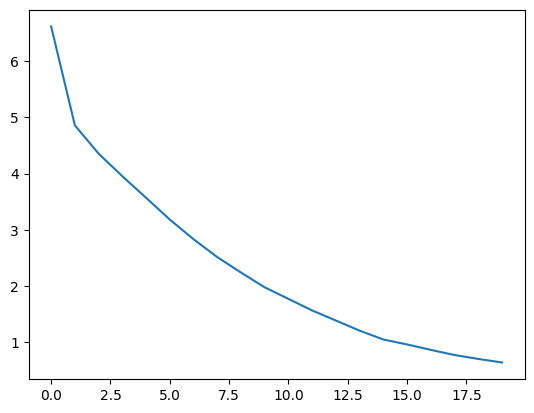

In [ ]:
plt.plot(loss_epochs)

In [ ]:
input_ids, labels_ids, data_attention_mask = train_dataset[3]

In [ ]:
@torch.no_grad()
def generate_batch(model, ids, is_decode = False, max_length = 20):

    model.eval()
    if type(ids) == list:
        symbols = torch.tensor(ids, device = DEVICE).view(len(ids),1)

    else:
        symbols = torch.tensor(ids, device = DEVICE).view(1,1)

    for _ in range(max_length - 1):

        cur_symbols = model(symbols).argmax(-1)[:, -1][:, None]
        symbols = torch.cat([symbols, cur_symbols], dim = 1)

    if is_decode:
        symbols = tokenizer.batch_decode(symbols, skip_special_tokens=True)
    return symbols

In [ ]:
generate_batch(model, ids = input_ids[0].item(), is_decode=True, max_length= 30)

['All: Caius Marcius Coriolanus!, call A man; and that a traitor and not indeed loved, nor shall be a foul']

In [ ]:
tokenizer.decode(labels_ids, skip_special_tokens=True)

': Resolved.'

In [ ]:
from torchtune.modules import RMSNorm

In [ ]:
from typing import Optional, Tuple
def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    """
    Precompute the frequency tensor for complex exponentials (cis) with given dimensions.

    This function calculates a frequency tensor with complex exponentials using the given dimension 'dim'
    and the end index 'end'. The 'theta' parameter scales the frequencies.
    The returned tensor contains complex values in complex64 data type.

    Args:
        dim (int): Dimension of the frequency tensor.
        end (int): End index for precomputing frequencies.
        theta (float, optional): Scaling factor for frequency computation. Defaults to 10000.0.

    Returns:
        torch.Tensor: Precomputed frequency tensor with complex exponentials.




    """
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device)  # type: ignore
    freqs = torch.outer(t, freqs).float()  # type: ignore
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis


def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    """
    Reshape frequency tensor for broadcasting it with another tensor.

    This function reshapes the frequency tensor to have the same shape as the target tensor 'x'
    for the purpose of broadcasting the frequency tensor during element-wise operations.

    Args:
        freqs_cis (torch.Tensor): Frequency tensor to be reshaped.
        x (torch.Tensor): Target tensor for broadcasting compatibility.

    Returns:
        torch.Tensor: Reshaped frequency tensor.

    Raises:
        AssertionError: If the frequency tensor doesn't match the expected shape.
        AssertionError: If the target tensor 'x' doesn't have the expected number of dimensions.
    """
    ndim = x.ndim
    assert 0 <= 1 < ndim
    assert freqs_cis.shape == (x.shape[1], x.shape[-1]), f'{freqs_cis.shape} - {(x.shape[1], x.shape[-1])}'
    shape = [d if i == 1 or i == ndim - 1 else 1 for i, d in enumerate(x.shape)]
    return freqs_cis.view(*shape)


def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Apply rotary embeddings to input tensors using the given frequency tensor.

    This function applies rotary embeddings to the given query 'xq' and key 'xk' tensors using the provided
    frequency tensor 'freqs_cis'. The input tensors are reshaped as complex numbers, and the frequency tensor
    is reshaped for broadcasting compatibility. The resulting tensors contain rotary embeddings and are
    returned as real tensors.

    Args:
        xq (torch.Tensor): Query tensor to apply rotary embeddings.
        xk (torch.Tensor): Key tensor to apply rotary embeddings.
        freqs_cis (torch.Tensor): Precomputed frequency tensor for complex exponentials.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Tuple of modified query tensor and key tensor with rotary embeddings.



    """
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)

In [ ]:
class MultiHeadAttentionRoPE(nn.Module):
    def __init__(self, d_model, n_heads, qkv_bias = True):
        super().__init__()
        assert d_model % n_heads == 0, "d_model is not divisible by h"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.query = nn.Linear(d_model, d_model, bias = qkv_bias)
        self.key = nn.Linear(d_model, d_model, bias = qkv_bias)
        self.value = nn.Linear(d_model, d_model, bias = qkv_bias)
        self.out = nn.Linear(d_model, d_model)
        self.scale = self.d_head ** -0.5

    def forward(self, x):
        B, S, D = x.shape
        query = self.query(x).view(B, S, self.n_heads, self.d_head)
        key = self.key(x).view(B, S, self.n_heads, self.d_head)
        value = self.value(x).view(B, S, self.n_heads, self.d_head).transpose(1,2)
        query, key = apply_rotary_emb(query, key, precompute_freqs_cis(self.d_head, 4096)[:S].to(next(iter(self.query.parameters())).device))
        query = query.transpose(1,2)
        key = key.transpose(1,2)

        dots = (query @ key.transpose(-1, -2)) * self.scale


        mask = torch.tril(torch.ones((S, S))).to(x.device)
        dots.masked_fill_(mask == 0, float('-inf'))

        att_scores = dots.softmax(-1)
        att_v = att_scores @ value

        out = att_v.permute(0, 2, 1, 3).contiguous().view(B, S, D)

        out = self.out(out)

        return out




In [ ]:
class FeedForwardllama(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.w1 = nn.Linear(d_model, 4 * d_model)
        self.w2 = nn.Linear(4 * d_model, d_model)
        self.w3 = nn.Linear(d_model, 4 * d_model)

    def forward(self, x):
        return self.w2(F.silu(self.w1(x)) * self.w3(x))

In [ ]:
class DecoderBlockllama(nn.Module):
    def __init__(self, d_model, n_heads, qkv_bias = True):
        super().__init__()
        self.RMSNorm_1 = RMSNorm(d_model)
        self.RMSNorm_2 = RMSNorm(d_model)

        self.MHA = MultiHeadAttentionRoPE(d_model, n_heads, qkv_bias)
        self.MLP = FeedForwardllama(d_model)

    def forward(self, x):

        x = self.MHA(self.RMSNorm_1(x)) + x
        x = self.MLP(self.RMSNorm_2(x)) + x

        return x


In [ ]:
class TransformerDecoderllama(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_blocks, qkv_bias = True, seq_len = 2048):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.blocks = nn.Sequential(*[DecoderBlockllama(d_model, n_heads, qkv_bias) for _ in range(n_blocks)])
        self.RMSNorn = RMSNorm(d_model)
        self.final_layer = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        x = x.to(next(iter(model.parameters())).device)
        emb = self.embedding(x)

        x = self.blocks(emb)
        x = self.RMSNorn(x)
        out = self.final_layer(x)

        return out

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
D_MODEL = 256
N_HEADS = 8
VOCAB_SIZE = len(tokenizer)
N_BLOCKS = 1
model_llama = TransformerDecoderllama(VOCAB_SIZE, D_MODEL, N_HEADS, N_BLOCKS).to(DEVICE).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
train_dataset = CustomDataset(train_sentences, tokenizer)
test_dataset = CustomDataset(test_sentences, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle = False)

In [ ]:
loss_fnc = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_llama.parameters(), lr=1e-3)

In [ ]:
model_llama.train()
loss_epochs = []
for epoch in tqdm(range(10)):
    loss_epoch = []
    for input_ids, labels_ids, data_attention_mask in tqdm(train_loader):
        input_ids = input_ids.to(DEVICE)
        labels_ids = labels_ids.to(DEVICE)
        data_attention_mask = data_attention_mask.to(DEVICE)

        preds = model_llama(input_ids)
        preds = preds[data_attention_mask]
        labels_ids = labels_ids[data_attention_mask]

        optimizer.zero_grad()
        loss = loss_fnc(preds, labels_ids)
        loss.backward()
        optimizer.step()
        loss_epoch.append(loss.item())

    print(f'Loss_epoch {epoch + 1}: {np.mean(loss_epoch)}')
    loss_epochs.append(np.mean(loss_epoch))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 1: 6.194635764808412


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 2: 4.738284022944748


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 3: 4.250940720746471


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 4: 3.8585795551348645


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 5: 3.4588485827111892


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 6: 3.02666294802526


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 7: 2.567799759518569


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 8: 2.116686393500893


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 9: 1.7056092449054596


  0%|          | 0/157 [00:00<?, ?it/s]

Loss_epoch 10: 1.3614490647224864


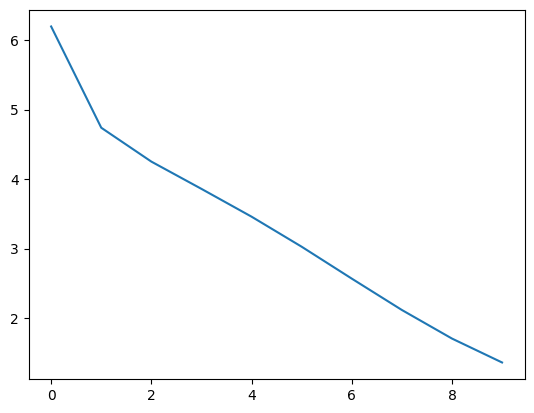

In [ ]:
plt.plot(loss_epochs)

In [ ]:
input_ids, labels_ids, data_attention_mask = train_dataset[2]

In [ ]:
@torch.no_grad()
def generate_batch(model, symbols, is_decode = False, max_length = 20):

    model.eval()
    # if type(ids) == list:
    #     symbols = torch.tensor(ids, device = DEVICE).view(len(ids),1)

    # else:
    #     symbols = torch.tensor(ids, device = DEVICE).view(1,1)

    for _ in range(max_length - 1):

        cur_symbols = model(symbols).argmax(-1)[:, -1][:, None]
        symbols = torch.cat([symbols, cur_symbols], dim = 1)

    if is_decode:
        symbols = tokenizer.batch_decode(symbols, skip_special_tokens=True)
    return symbols

In [ ]:
generate_batch(model_llama, input_ids[:2].view(1, -1).to(DEVICE), is_decode=True, max_length= 28)

['First Citizen: He has our voices, sir. strange one of us?--I know not--but,-- CAMILLO, but are']

In [ ]:
tokenizer.decode(input_ids, skip_special_tokens=True)

'First Citizen: You are all resolved rather to die than to famish?'

In [ ]:
num = 0

for p in model.parameters():
  num+= p.numel()
num

60970577

In [ ]:
num = 0

for p in model_llama.parameters():
  num+= p.numel()
num

26834513